In [1]:
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import numpy as np
import sklearn

In [3]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "images/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        

Found 1705 files belonging to 5 classes.
Using 1364 files for training.
Found 1705 files belonging to 5 classes.
Using 341 files for validation.


In [4]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
for layer in base_model.layers:
    layer.trainable = True


avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(14, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [5]:
optimizer = keras.optimizers.Adam(learning_rate=0.002)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= optimizer,
              metrics=["accuracy"])

In [6]:
history = model.fit(train_ds, epochs=10,
                     validation_steps = 10,
                    validation_data=validation_ds)

Epoch 1/10
43/43 [==============================] - 141s 3s/step - loss: 0.8989 - accuracy: 0.7207 - val_loss: 11.3600 - val_accuracy: 0.4094
Epoch 2/10
43/43 [==============================] - 138s 3s/step - loss: 0.4713 - accuracy: 0.8570 - val_loss: 9.7626 - val_accuracy: 0.5531
Epoch 3/10
43/43 [==============================] - 143s 3s/step - loss: 0.2002 - accuracy: 0.9435 - val_loss: 13.3164 - val_accuracy: 0.4688
Epoch 4/10
43/43 [==============================] - 155s 4s/step - loss: 0.3581 - accuracy: 0.8893 - val_loss: 4.2068 - val_accuracy: 0.4656
Epoch 5/10
43/43 [==============================] - 156s 4s/step - loss: 0.2043 - accuracy: 0.9296 - val_loss: 13.5966 - val_accuracy: 0.2969
Epoch 6/10
43/43 [==============================] - 139s 3s/step - loss: 0.2083 - accuracy: 0.9304 - val_loss: 10.3070 - val_accuracy: 0.6062
Epoch 7/10
43/43 [==============================] - 142s 3s/step - loss: 0.1575 - accuracy: 0.9479 - val_loss: 3.7313 - val_accuracy: 0.6594
Epoch 8/1

In [8]:
layer = model.get_layer(name="conv2d_1")
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [12]:
# "loss" will be maximized in the gradient ascent process
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [9]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [10]:
img_width = 150
img_height = 150

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


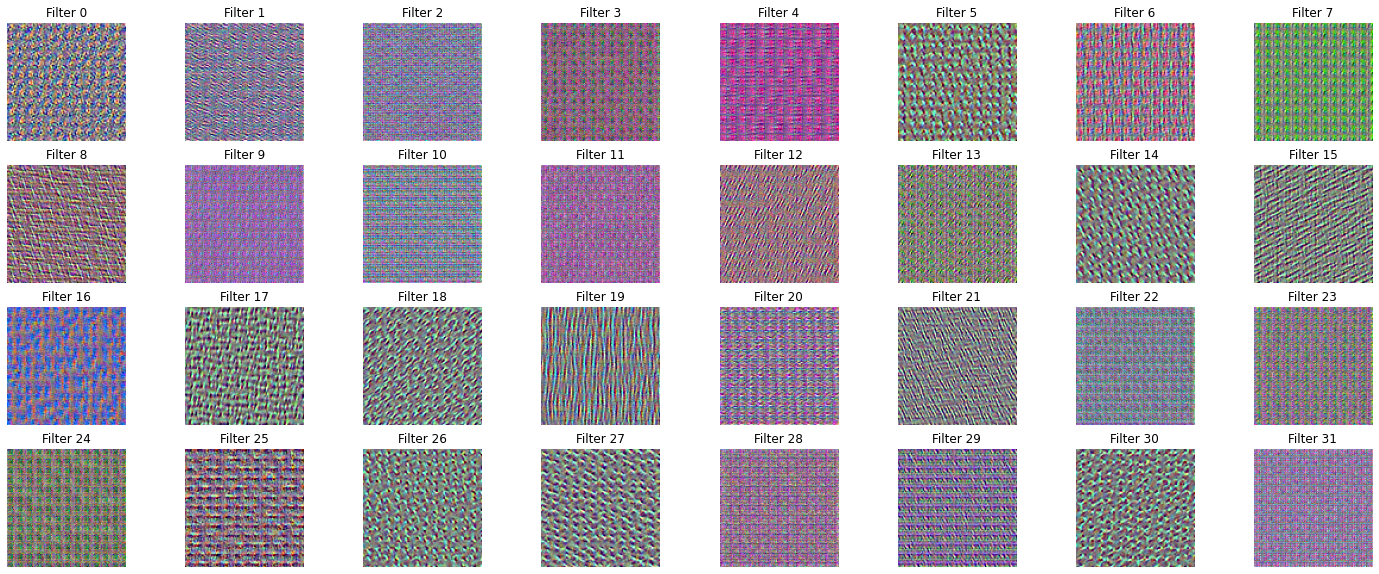

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
for i in range(32):
  loss, img = visualize_filter(i)
  plt.subplot(4,8,i+1)
  plt.title(f'Filter {i}')
  plt.imshow(img)
  plt.axis('off')

In [14]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.scores import CategoricalScore

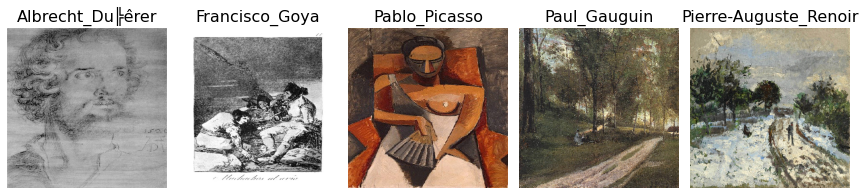

In [15]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_1.jpg', target_size=(299, 299))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_1.jpg', target_size=(299, 299))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_1.jpg', target_size=(299, 299))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_1.jpg', target_size=(299, 299))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_1.jpg', target_size=(299, 299))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

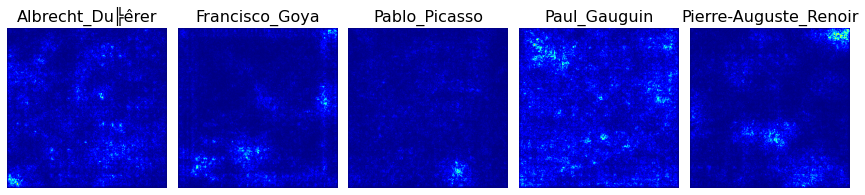

In [19]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(keras.applications.xception.Xception(),
           model_modifier=[ExtractIntermediateLayer('block14_sepconv1'),
                           ReplaceToLinear()],
           clone=False)

# 1 is the imagenet index corresponding to each image
score = CategoricalScore([1, 200, 350, 413, 540])

# Generate saliency map
saliency_map = saliency(score, X)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

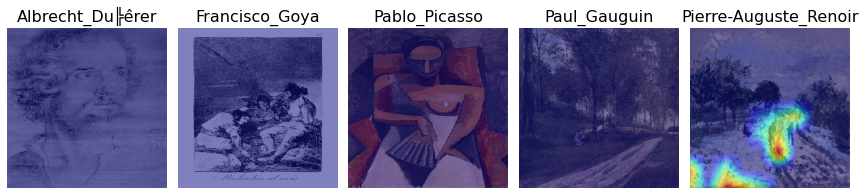

In [20]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(keras.applications.xception.Xception(),
                  model_modifier=[ExtractIntermediateLayer('block14_sepconv1'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [21]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_2.jpg', target_size=(299, 299))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_2.jpg', target_size=(299, 299))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_2.jpg', target_size=(299, 299))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_2.jpg', target_size=(299, 299))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_2.jpg', target_size=(299, 299))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)


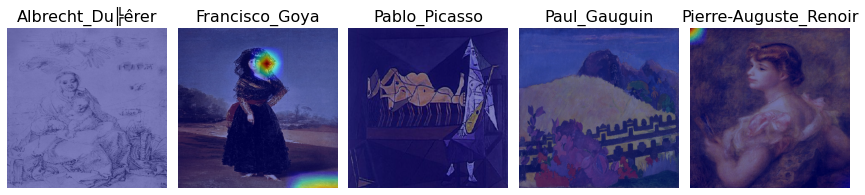

In [22]:
# Create Gradcam object
gradcam = Gradcam(keras.applications.xception.Xception(),
                  model_modifier=[ExtractIntermediateLayer('block14_sepconv1'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [23]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_3.jpg', target_size=(299, 299))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_3.jpg', target_size=(299, 299))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_3.jpg', target_size=(299, 299))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_3.jpg', target_size=(299, 299))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_3.jpg', target_size=(299, 299))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)


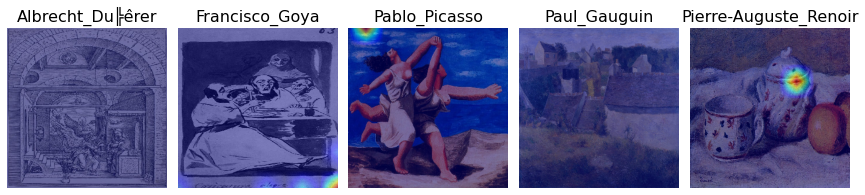

In [24]:
# Create Gradcam object
gradcam = Gradcam(keras.applications.xception.Xception(),
                  model_modifier=[ExtractIntermediateLayer('block14_sepconv1'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [25]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_4.jpg', target_size=(299, 299))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_4.jpg', target_size=(299, 299))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_4.jpg', target_size=(299, 299))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_4.jpg', target_size=(299, 299))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_4.jpg', target_size=(299, 299))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)


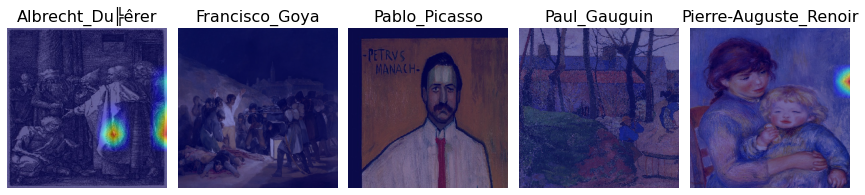

In [26]:
# Create Gradcam object
gradcam = Gradcam(keras.applications.xception.Xception(),
                  model_modifier=[ExtractIntermediateLayer('block14_sepconv1'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [27]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_5.jpg', target_size=(299, 299))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_5.jpg', target_size=(299, 299))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_5.jpg', target_size=(299, 299))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_5.jpg', target_size=(299, 299))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_5.jpg', target_size=(299, 299))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)


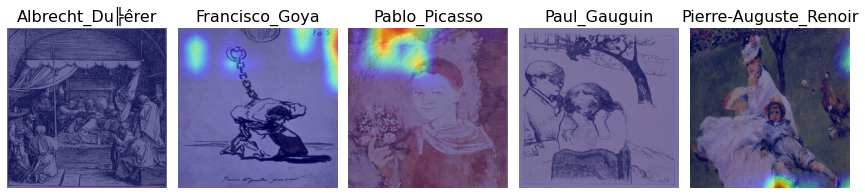

In [28]:
# Create Gradcam object
gradcam = Gradcam(keras.applications.xception.Xception(),
                  model_modifier=[ExtractIntermediateLayer('block14_sepconv1'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model2 = VGG16(weights="imagenet", include_top=False)

for layer in base_model2.layers:
    layer.trainable = True

58900480/58889256 [==============================] - 4s 0us/step


In [31]:
avg = keras.layers.GlobalAveragePooling2D()(base_model2.output)
output = keras.layers.Dense(18, activation="softmax")(avg)
model2 = keras.models.Model(inputs=base_model2.input, outputs=output)

In [33]:
optimizer = keras.optimizers.Adam(learning_rate=0.002)

model2.compile(loss="sparse_categorical_crossentropy",
              optimizer= optimizer,
              metrics=["accuracy"])



In [35]:
history2 = model2.fit(train_ds, epochs=10,
                     validation_steps = 10,
                    validation_data=(validation_ds))

Epoch 1/10
43/43 [==============================] - 211s 5s/step - loss: 151.3981 - accuracy: 0.2309 - val_loss: 3.5201 - val_accuracy: 0.2562
Epoch 2/10
43/43 [==============================] - 209s 5s/step - loss: 1.7677 - accuracy: 0.2544 - val_loss: 1.6186 - val_accuracy: 0.2688
Epoch 3/10
43/43 [==============================] - 196s 5s/step - loss: 1.5198 - accuracy: 0.3101 - val_loss: 1.5108 - val_accuracy: 0.3125
Epoch 4/10
43/43 [==============================] - 192s 4s/step - loss: 1.4514 - accuracy: 0.3732 - val_loss: 1.7355 - val_accuracy: 0.2906
Epoch 5/10
43/43 [==============================] - 189s 4s/step - loss: 1.4279 - accuracy: 0.3849 - val_loss: 1.3952 - val_accuracy: 0.3562
Epoch 6/10
43/43 [==============================] - 188s 4s/step - loss: 1.3746 - accuracy: 0.3922 - val_loss: 1.4113 - val_accuracy: 0.3438
Epoch 7/10
43/43 [==============================] - 188s 4s/step - loss: 1.2867 - accuracy: 0.4633 - val_loss: 1.3321 - val_accuracy: 0.4406
Epoch 8/10


In [37]:
layer = model2.get_layer(name="block3_conv2")
feature_extractor = keras.Model(inputs=model2.inputs, outputs=layer.output)

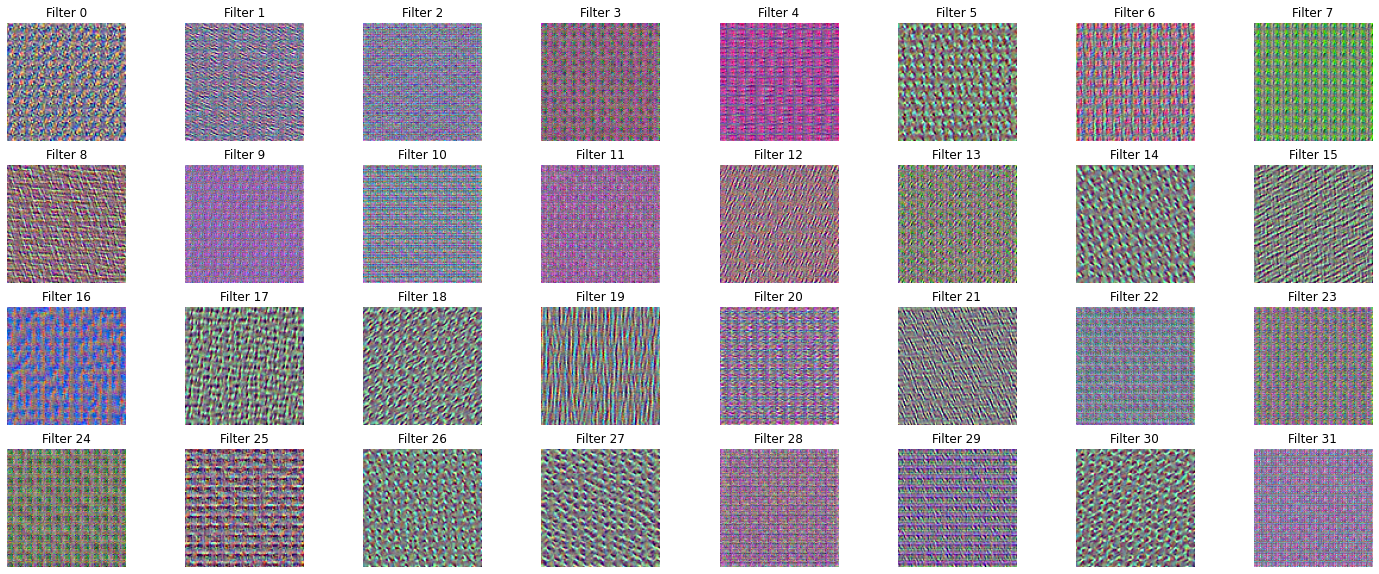

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
for i in range(32):
  loss, img = visualize_filter(i)
  plt.subplot(4,8,i+1)
  plt.title(f'Filter {i}')
  plt.imshow(img)
  plt.axis('off')

In [41]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_1.jpg', target_size=(224, 224))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_1.jpg', target_size=(224, 224))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_1.jpg', target_size=(224, 224))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_1.jpg', target_size=(224, 224))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_1.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)

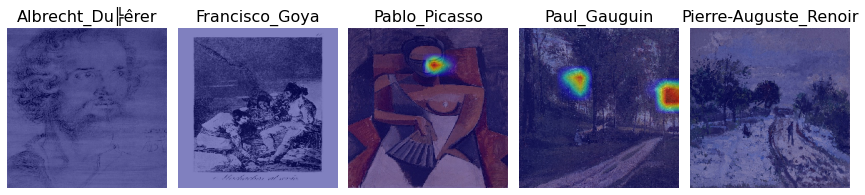

In [43]:
# Create Gradcam object
score = CategoricalScore([1, 200, 350, 413])

gradcam = Gradcam(VGG16(),
                  model_modifier=[ExtractIntermediateLayer('block5_conv3'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [45]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_2.jpg', target_size=(224, 224))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_2.jpg', target_size=(224, 224))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_2.jpg', target_size=(224, 224))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_2.jpg', target_size=(224, 224))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_2.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)

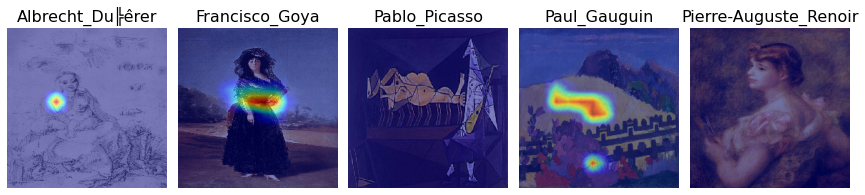

In [46]:
# Create Gradcam object
gradcam = Gradcam(VGG16(),
                  model_modifier=[ExtractIntermediateLayer('block5_conv3'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [47]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_3.jpg', target_size=(224, 224))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_3.jpg', target_size=(224, 224))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_3.jpg', target_size=(224, 224))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_3.jpg', target_size=(224, 224))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_3.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)

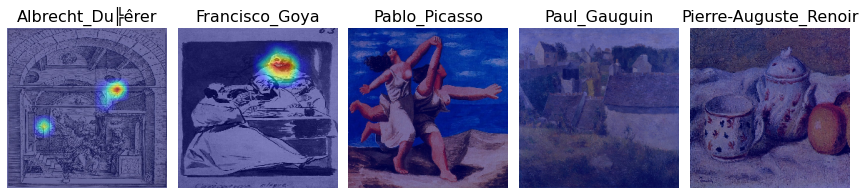

In [48]:
# Create Gradcam object
gradcam = Gradcam(VGG16(),
                  model_modifier=[ExtractIntermediateLayer('block5_conv3'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [50]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_4.jpg', target_size=(224, 224))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_4.jpg', target_size=(224, 224))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_4.jpg', target_size=(224, 224))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_4.jpg', target_size=(224, 224))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_4.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)

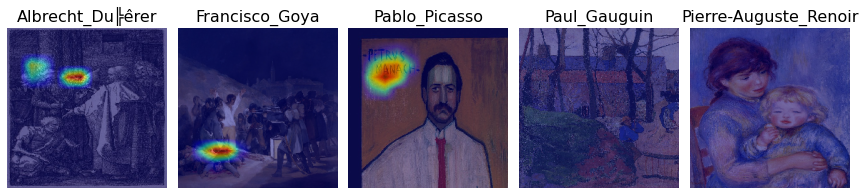

In [51]:
# Create Gradcam object
gradcam = Gradcam(VGG16(),
                  model_modifier=[ExtractIntermediateLayer('block5_conv3'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [52]:
# Image titles
image_titles = ['Albrecht_Du╠êrer', 'Francisco_Goya', 'Pablo_Picasso', 'Paul_Gauguin', 'Pierre-Auguste_Renoir']

# Load images and Convert them to a Numpy array
img1 = load_img('images/Albrecht_Du╠êrer/Albrecht_Du╠êrer_5.jpg', target_size=(224, 224))
img2 = load_img('images/Francisco_Goya/Francisco_Goya_5.jpg', target_size=(224, 224))
img3 = load_img('images/Pablo_Picasso/Pablo_Picasso_5.jpg', target_size=(224, 224))
img4 = load_img('images/Paul_Gauguin/Paul_Gauguin_5.jpg', target_size=(224, 224))
img5 = load_img('images/Pierre-Auguste_Renoir/Pierre-Auguste_Renoir_5.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4), np.array(img5)])


X = preprocess_input(images)

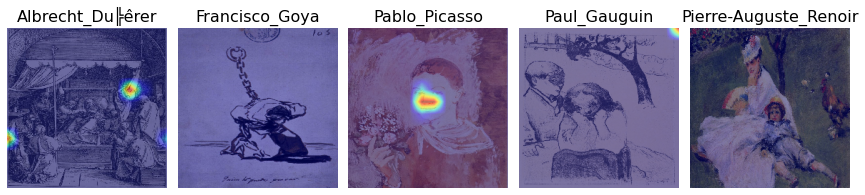

In [53]:
# Create Gradcam object
gradcam = Gradcam(VGG16(),
                  model_modifier=[ExtractIntermediateLayer('block5_conv3'),
                           ReplaceToLinear()],
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# Render
f, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()